In [1]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Read in the Data
The data (included) contains the passenger manifest from the [Titanic Disaster](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic).  We'll use some of the data preparation techniques to investigate the data, and build a predictive model.

In [2]:
dat = pd.read_csv("../data/titanic.csv")
dat

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


There is a mix of datatypes here, including some categorical and boolean types.  It looks like some of the values may be missing (NaN).  Let's see which columns have missing values.

In [3]:
dat.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

There are a few columns that have missing values, how many of them are there?

In [4]:
dat.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that cabin number is missing for almost all passengers.  Cabins might have had wealthy patrons, which may have affected their survivability. Let's recode this to a simple boolean entry (if it is present or not)

In [5]:
dat.Cabin = ~dat.Cabin.isna()
dat.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64

It looks like "embarked" is the port the passenger originated from.  This is a coded value for the port name  (C = Cherbourg; Q = Queenstown; S = Southampton)

In [6]:
dat.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

It looks like most folks got on at Southampton.  Since there's only two people with missing embarkations, let's put them with the modal class, *Southampton*.  This is a simple form of imputation, and it's worth mentioning that different methods of imputation are appropriate in different contexts.

In [7]:
dat.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [8]:
dat.loc[dat.Embarked.isna(), "Embarked"] = "S"
dat.Embarked.value_counts(dropna=False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Let's look age now... 

<AxesSubplot:>

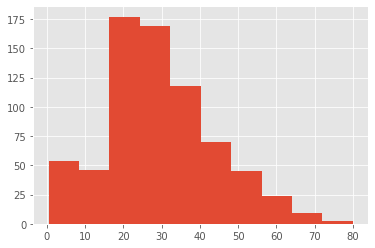

In [9]:
dat.Age.hist()

By "pivoting" the data, we can get pandas to plot a stacked histogram, which lets us see how the distributions of ages differed, depending on whether they survived or not.

<AxesSubplot:ylabel='Frequency'>

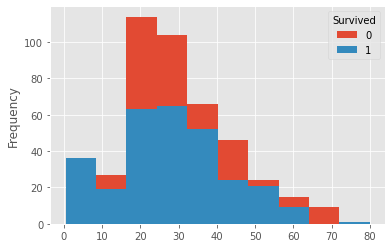

In [10]:
dat[["Age","Survived"]].pivot(columns="Survived", values="Age").plot.hist()


There's clearly an effect here.  However, for now let's fill in the missing ages with the over all means.

In [11]:
dat.loc[dat.Age.isna(), "Age"] = dat.Age.mean()
dat.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

(Open question: what's a better way to impute the age here?)

In [12]:
# PassengerId is not going to be useful for modeling since it is unique to the passenger
dat = dat.drop("PassengerId", axis=1)

Tickets are also *usually* specific to an individual, although in some cases entire families were on a single ticket. We'll drop them for now, since we'd need to do a fair amount of digging to interpret the ticket codes.

In [13]:
dat.Ticket.value_counts()

CA. 2343      7
347082        7
1601          7
CA 2144       6
3101295       6
             ..
330923        1
2647          1
350048        1
C.A. 29178    1
349249        1
Name: Ticket, Length: 681, dtype: int64

In [14]:
dat = dat.drop("Ticket", axis=1)

Names are also specific to the passenger, and aren't useful to model.  However!  The names here include other information, such as titles that hint at class and gender.  What would be a good way to extract this information?

In [15]:
dat.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [16]:
dat = dat.drop("Name", axis=1)

Let's convert Sex to a simple boolean variable

In [17]:
dat.Sex = dat.Sex == "female"
dat

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,False,22.000000,1,0,7.2500,False,S
1,1,1,True,38.000000,1,0,71.2833,True,C
2,1,3,True,26.000000,0,0,7.9250,False,S
3,1,1,True,35.000000,1,0,53.1000,True,S
4,0,3,False,35.000000,0,0,8.0500,False,S
...,...,...,...,...,...,...,...,...,...
886,0,2,False,27.000000,0,0,13.0000,False,S
887,1,1,True,19.000000,0,0,30.0000,True,S
888,0,3,True,29.699118,1,2,23.4500,False,S
889,1,1,False,26.000000,0,0,30.0000,True,C


We can create dummy "one-hot" encodings using the base pandas `get_dummies` method:

In [18]:
pd.get_dummies(dat.Embarked)

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


Let's replace the original embarked column with these columns

In [19]:
dat = pd.concat([dat.drop("Embarked", axis=1), pd.get_dummies(dat.Embarked, prefix="Embarked_")], axis=1)
dat

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked__C,Embarked__Q,Embarked__S
0,0,3,False,22.000000,1,0,7.2500,False,0,0,1
1,1,1,True,38.000000,1,0,71.2833,True,1,0,0
2,1,3,True,26.000000,0,0,7.9250,False,0,0,1
3,1,1,True,35.000000,1,0,53.1000,True,0,0,1
4,0,3,False,35.000000,0,0,8.0500,False,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,False,27.000000,0,0,13.0000,False,0,0,1
887,1,1,True,19.000000,0,0,30.0000,True,0,0,1
888,0,3,True,29.699118,1,2,23.4500,False,0,0,1
889,1,1,False,26.000000,0,0,30.0000,True,1,0,0


Now that everything is in a numeric-like format, let's see how some of the features are related here.

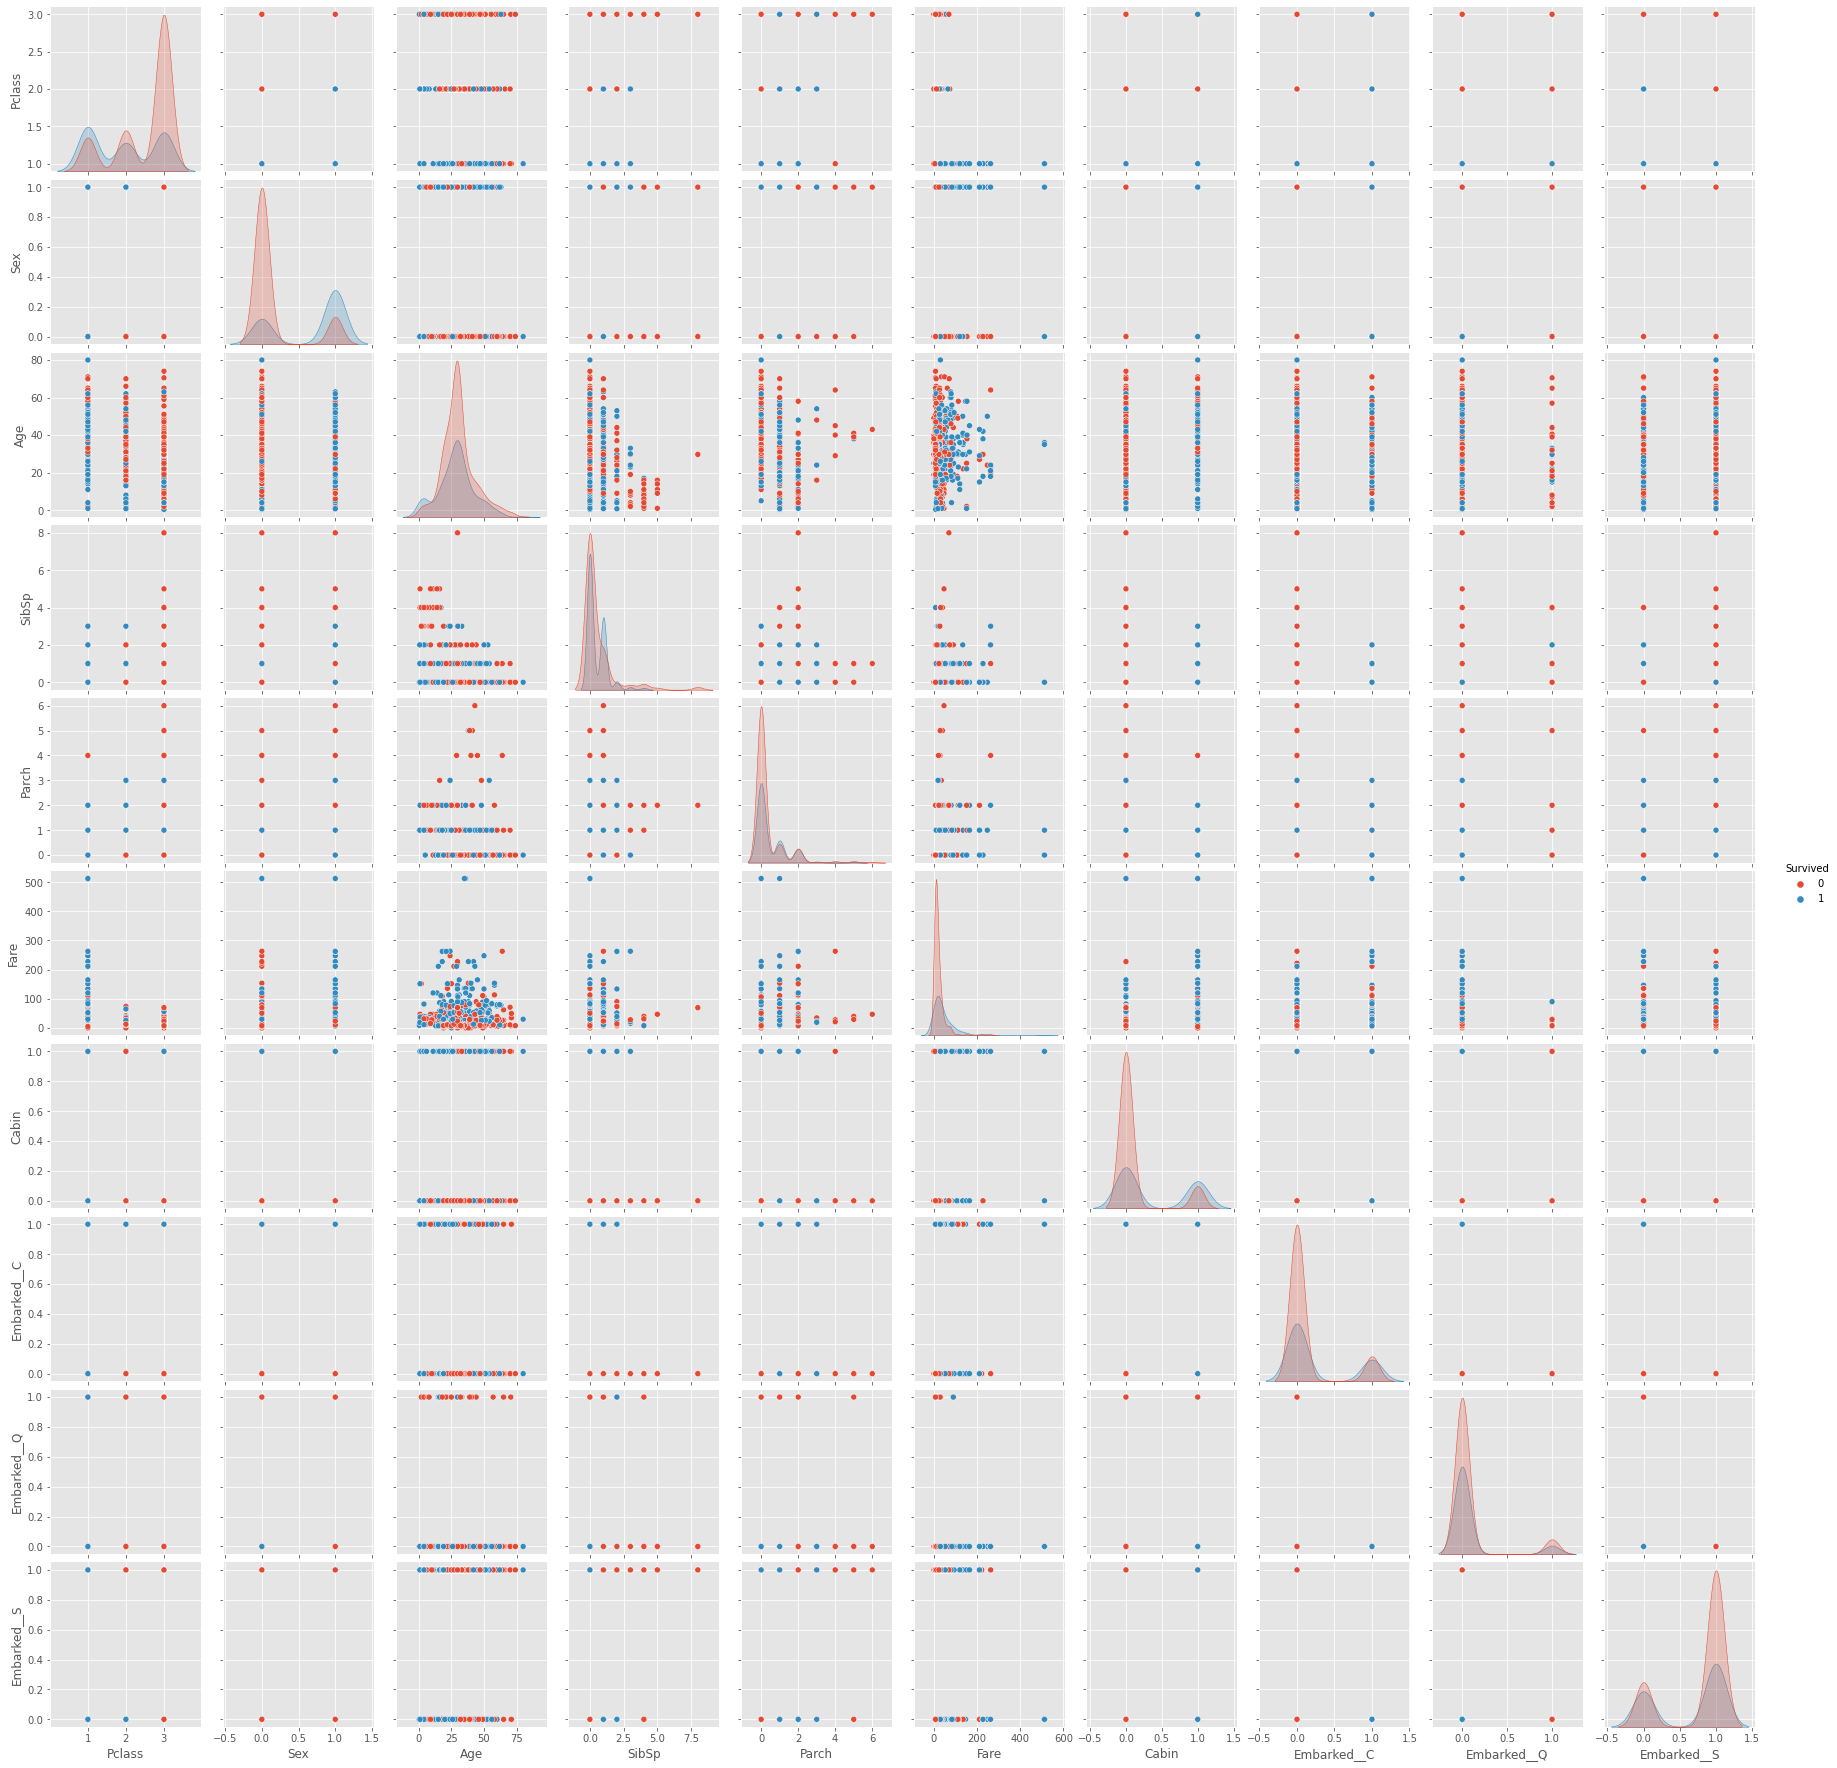

In [20]:
sns.pairplot(dat, hue="Survived")

In [27]:
X = dat.drop("Survived",axis=1)
y = dat.Survived
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [30]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, solver='liblinear', multi_class='auto')
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [32]:
import numpy as np

y_pred = classifier.predict(X_test)
probs_y=classifier.predict_proba(X_test)
probs_y = np.round(probs_y, 2)

We can look at the confusion matrix, and see our true positives and negatives vs. our mistakes.
```
True Positive  | False Positive
False Negative | True Negative
```

In [34]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[118  21]
 [ 20  64]]


Let's construct an ROC curve for this model

In [41]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [46]:
classifier.predict_proba(X_test)[:10]

array([[0.84385572, 0.15614428],
       [0.88842203, 0.11157797],
       [0.91153335, 0.08846665],
       [0.05695638, 0.94304362],
       [0.30422841, 0.69577159],
       [0.49937338, 0.50062662],
       [0.08342835, 0.91657165],
       [0.06678791, 0.93321209],
       [0.42412323, 0.57587677],
       [0.29015378, 0.70984622]])

The `predict_proba` function gives us functions for both positive and negative classes.  These are always the inverse of eachother, so we can just take the probability of a positive result (Survived)

In [51]:
probs = classifier.predict_proba(X_test)
probs = probs[:,1]
probs[:10]

array([0.15614428, 0.11157797, 0.08846665, 0.94304362, 0.69577159,
       0.50062662, 0.91657165, 0.93321209, 0.57587677, 0.70984622])

In [53]:
from sklearn.metrics import roc_curve  
fper, tper, thresholds = roc_curve(y_test, probs)

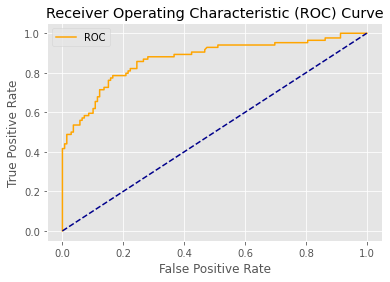

In [55]:
plot_roc_cur(fper, tper)